<a href="https://colab.research.google.com/github/rcd27/textclassifier/blob/master/1_text_classification_with_neural_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Вводная

In [ ]:
from keras.preprocessing.text import Tokenizer

In [ ]:
# TODO: russian text
documents = [
    'The quick brown fox',
    'Jumps over $$$ the lazy brown dog',
    'Who jumps high into the blue sky after counting 123',
    'And quickly returns to earth'
]
 
tokenizer = Tokenizer()

# Создаёт словарь(внутренний у себя там) со всеми словами
tokenizer.fit_on_texts(documents)

# Просто лист листов с индексами(где вложенный лист - строка)
sequences = tokenizer.texts_to_sequences(documents)

print(sequences)

[[1, 4, 2, 5], [3, 6, 1, 7, 2, 8], [9, 3, 10, 11, 1, 12, 13, 14, 15, 16], [17, 18, 19, 20, 21]]


Но эти приёмы не удаляют "стоп-слова" или числа(короче всякий мусор). Если хотим почистить, то можно использовать Natural Language Toolkit(https://www.nltk.org/)

In [ ]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
def remove_stop_words(text):
    text = word_tokenize(text.lower())
    stop_words = set(stopwords.words('english')) # TODO: russian
    text = [word for word in text if word.isalpha() and not word in stop_words]
    return ' '.join(text)

In [ ]:
documents_without_stop_words = list(map(remove_stop_words, documents))
tokenizer_no_stop_words = Tokenizer()
tokenizer_no_stop_words.fit_on_texts(documents_without_stop_words)
filtered_sequenses = tokenizer_no_stop_words.texts_to_sequences(documents_without_stop_words)

print(filtered_sequenses)

[[3, 1, 4], [2, 5, 1, 6], [2, 7, 8, 9, 10], [11, 12, 13]]


Длина получившихся "строк" массивов - разная, но нейронке на вход нужны "одинаковые". Для этого юзанём `pad_sequences` из `Keras`.

In [ ]:
from keras.utils import pad_sequences

padded_sequences = pad_sequences(filtered_sequenses, maxlen=4)
print(padded_sequences)

[[ 0  3  1  4]
 [ 2  5  1  6]
 [ 7  8  9 10]
 [ 0 11 12 13]]


Как только текст токенизирован и разбит на выравненные последовательности, он готов для того, чтобы тренировать нейронку.

Первый слой, который классифицирует текст - [embedding layer](https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/). Его задача конвертнуть выровненные последовательности индексов слов в массивы [векторов слов](https://dzone.com/articles/introduction-to-word-vectors). Эти вектора представляют слова в виде дробных чисел, а не интов. Таким образом(если мы анализируем эмоциональную окраску), слова типа "восхитительно" или "замечательно" для нейронки на вход становятся "близкими по значению". В керасе для таких движух есть готовый класс `Embedding`

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers import Embedding

model = Sequential() 
# {размер словаря, количество измерений, длина входящих последовательностей}
model.add(Embedding(10000, 32, input_length=100)) 
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Каждое слово енкодиться в выбранное количество измерений(второй аргумент функции) Для каждой последовательности, выходные данные из `embedding layer` - 2D матрица дробных чисел m*n. Каждая "строка" входного массива конвертируется в массив слов-векторов. Слой `Flatten` всхлопывает 2D матрицу в 1D массив, подходящий для слоя `Dense`, который в свою очередь уже занимается классификацией. Можно экспериментировать с разным числом для размерности(dimensions) и длин в `embedding layer`, разным количеством нейронов в `dense` слое для повышения точности(accuracy). Также можно добавить больше `dense` слоёв.

Векторы, олицетворяющие отдельные слова в `embedding layer` "изучаются" в процессе тренировки модели, таким же образом как и веса в `dense layer`. Если количество данных для тренировки существенно велико, то результат тренировки такой модели показывает довольно высокую точность в переводе слов в векторы. В случае, если для тренировки используется несколько сотен текстов, то как бы потом не удивляйтесь.

В таком случае(малого количества входных данных), можно использовать претренированные `word embeddings` для `embedding` слоя. Существует несколько таких претренированных эмбеддингов ([GloVe](https://nlp.stanford.edu/projects/glove/) например). Эти модели служат для определения семантических связей между словами. Например "король" и "королева" как бы относящиеся друг другу по смыслу. В то время, как "зебра" и "лестница" - нет. Но так как классификация текста - довольно специфическая, узконаправленная задача, то натренированные вручную модели зачастую работают лучше(от Стсн.: то есть, надо понмать, если мы хотим для Игоря добавить тэг "технический вопрос", то нейронку нужно тренировать самим, причём использовать для этого дата-сет из сообщений, которые пишут _ему_) см: [использование pre-trained word embeddings](https://keras.io/examples/nlp/pretrained_word_embeddings/)

#### Классификация текста, вышедшего из `Embedding Layer`

Одним из недостатков классификации предыдущего "выхода" из embedding layer в dense layer - последний воспринимет слова независимо, не учитывая среднюю температуру по больнице. Если слова типа "кредитная" "карта" "долг" повышают шанс, что текст - спам про чё-то типа получите изи деньги, то dense layer'у на это похую, он не берёт во внимание такие "мелочи" лол.

Одним из приёмов обхода данного недоразумения может быть замена dense слоёв на [Conv1D](https://keras.io/api/layers/convolution_layers/convolution1d/) и [MaxPooling1D](https://keras.io/api/layers/pooling_layers/max_pooling1d/), что как бы делает из нашей нейронки `convolutional neural network`, CNN. CNN широко используются для классификации изображений. То также находят своё применение и в классификации текста.

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from keras.layers import Embedding
 
model = Sequential()
model.add(Embedding(10000, 32, input_length=100))
model.add(Conv1D(32, 7, activation='relu'))
model.add(MaxPooling1D(5))
model.add(Conv1D(32, 7, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Вместо того, чтобы оценивать слова по-отдельности, `Conv1D` слои берут слайсы по 7 слов. `MaxPooling1D` снижает размерность предыдующего вывода (первого `Conv1D`) с тем, чтобы "подсветить" важные элементы. Более подробно описано в следующей статье, но сейчас достаточно впитать факт, что такая простая сиэнэнка даёт более акууратные результаты в классификации текста, нежели предыдующая c `Dense` слоем.

Другим вариком является добавление [long-short-term memory](https://en.wikipedia.org/wiki/Long_short-term_memory) слоёв (см. [LSTM](https://keras.io/api/layers/recurrent_layers/lstm/). Это делает из нейронки [recurrent neural network](https://en.wikipedia.org/wiki/Recurrent_neural_network), иначе говоря RNN. Такие нейронки тоже неплохо справляются с классификацией текста (также гуд как CNN), но их дольше тренировать


### А щас короче напишем нейронку, которая детектит спам

https://raw.githubusercontent.com/jeffprosise/Deep-Learning/master/Data/ham-spam.csv

In [ ]:
# mount google drive with google colaboratory
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
 
df = pd.read_csv('./drive/MyDrive/ML/ham-spam.csv')
df.head()

,IsSpam,Text
0,0,key issues going forwarda year end reviews rep...
1,0,congrats contratulations the execution the cen...
2,0,key issues going forwardall under control set...
3,0,epmi files protest entergy transcoattached our...
4,0,california power please contact kristin walsh ...


In [ ]:
# Убираем дупликаты
df = df.drop_duplicates()
df.groupby('IsSpam').describe()

Text                                                               
       count unique                                                top freq
IsSpam                                                                     
0        499    499  key issues going forwarda year end reviews rep...    1
1        500    500  take the reinsbecomeyour employer substantial ...    1

In [ ]:
x = df.apply(lambda row: remove_stop_words(row['Text']), axis=1)
y = df['IsSpam']

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
 
max_words = 20000
max_length = 500
 
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(x)
sequences = tokenizer.texts_to_sequences(x)
x = pad_sequences(sequences, maxlen=max_length)

Бинарная классификация с `Dense` в основе и выводом в виде одного нейрона с сигмоидной активацией

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers import Embedding
 
model = Sequential() 
model.add(Embedding(max_words, 32, input_length=max_length)) 
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 500, 32)           640000    
                                                                 
 flatten_1 (Flatten)         (None, 16000)             0         
                                                                 
 dense_3 (Dense)             (None, 128)               2048128   
                                                                 
 dense_4 (Dense)             (None, 1)                 129       
                                                                 
Total params: 2,688,257
Trainable params: 2,688,257
Non-trainable params: 0
_________________________________________________________________


Тренировка нейронки с использованием рандомных 20% для валидации

In [ ]:
hist = model.fit(x, y, validation_split=0.2, epochs=5, batch_size=20)

Epoch 1/5
40/40 [==============================] - 9s 81ms/step - loss: 0.6705 - accuracy: 0.6158 - val_loss: 0.6741 - val_accuracy: 0.7350
Epoch 2/5
40/40 [==============================] - 2s 53ms/step - loss: 0.4258 - accuracy: 0.8486 - val_loss: 0.5891 - val_accuracy: 0.8000
Epoch 3/5
40/40 [==============================] - 2s 50ms/step - loss: 0.1333 - accuracy: 0.9887 - val_loss: 0.2059 - val_accuracy: 0.9750
Epoch 4/5
40/40 [==============================] - 2s 55ms/step - loss: 0.0370 - accuracy: 0.9950 - val_loss: 0.4093 - val_accuracy: 0.7950
Epoch 5/5
40/40 [==============================] - 2s 58ms/step - loss: 0.0194 - accuracy: 0.9962 - val_loss: 0.1881 - val_accuracy: 0.9300


Используем объект `hist`, возвращённый методом `fit`, отобразим в `plot`

[]

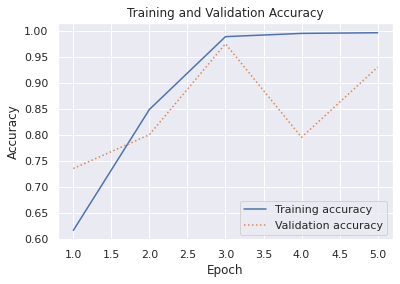

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set()
 
acc = hist.history['accuracy']
val = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)
 
plt.plot(epochs, acc, '-', label='Training accuracy')
plt.plot(epochs, val, ':', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

Зажмурив глаза, надеемся, что `accuracy` ударило 90% где-то в серединке. Если нет, перетренировать нейронку.

Це была `dense` нейронка, теперь попробуем `CNN`

In [ ]:
from keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D
 
model = Sequential()
model.add(Embedding(max_words, 32, input_length=max_length))
model.add(Conv1D(32, 7, activation='relu'))
model.add(MaxPooling1D(5))
model.add(Conv1D(32, 7, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 500, 32)           640000    
                                                                 
 conv1d_2 (Conv1D)           (None, 494, 32)           7200      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 98, 32)           0         
 1D)                                                             
                                                                 
 conv1d_3 (Conv1D)           (None, 92, 32)            7200      
                                                                 
 global_max_pooling1d_1 (Glo  (None, 32)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_5 (Dense)             (None, 1)                

In [ ]:
hist = model.fit(x, y, validation_split=0.2, epochs=5, batch_size=20)

Epoch 1/5
40/40 [==============================] - 3s 50ms/step - loss: 0.6545 - accuracy: 0.6195 - val_loss: 0.9148 - val_accuracy: 0.0000e+00
Epoch 2/5
40/40 [==============================] - 3s 66ms/step - loss: 0.5035 - accuracy: 0.6483 - val_loss: 0.7605 - val_accuracy: 0.5800
Epoch 3/5
40/40 [==============================] - 3s 67ms/step - loss: 0.2490 - accuracy: 0.9524 - val_loss: 0.2847 - val_accuracy: 0.9550
Epoch 4/5
40/40 [==============================] - 2s 43ms/step - loss: 0.0629 - accuracy: 0.9850 - val_loss: 0.1599 - val_accuracy: 0.9650
Epoch 5/5
40/40 [==============================] - 2s 44ms/step - loss: 0.0263 - accuracy: 0.9925 - val_loss: 0.0881 - val_accuracy: 0.9900


[]

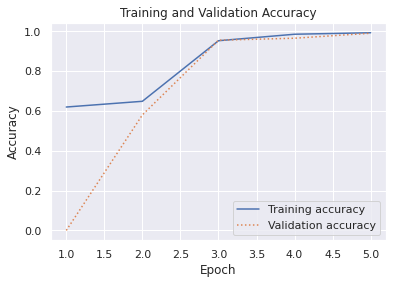

In [ ]:
acc = hist.history['accuracy']
val = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)
 
plt.plot(epochs, acc, '-', label='Training accuracy')
plt.plot(epochs, val, ':', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

In [ ]:
# тестанём
cleaned_text = remove_stop_words('Can you attend a code review on Tuesday? Need to make sure the logic is rock solid.')
sequence = tokenizer.texts_to_sequences([cleaned_text])
padded_sequence = pad_sequences(sequence, maxlen=max_length)
model.predict(padded_sequence)[0][0]


1/1 [==============================] - 0s 127ms/step


0.20376647

In [ ]:
cleaned_text = remove_stop_words('Why pay more for expensive meds when you can order them online and save $$$?')
sequence = tokenizer.texts_to_sequences([cleaned_text])
padded_sequence = pad_sequences(sequence, maxlen=max_length)
model.predict(padded_sequence)[0][0]

1/1 [==============================] - 0s 24ms/step


0.79254276

#### Ля, а чё теперь всё-время вручную токенизацией заниматься?

Нет. Для таких делов есть специальный слой в керасе. Называется `TextVectorization` (https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, TextVectorization, InputLayer
from keras.layers import Embedding
import tensorflow as tf
 
model = Sequential()
model.add(InputLayer(input_shape=(1,), dtype=tf.string))
model.add(TextVectorization(max_tokens=max_words, output_sequence_length=max_length))
model.add(Embedding(max_words, 32, input_length=max_length))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_3 (TextV  (None, 500)              0         
 ectorization)                                                   
                                                                 
 embedding_7 (Embedding)     (None, 500, 32)           640000    
                                                                 
 flatten_5 (Flatten)         (None, 16000)             0         
                                                                 
 dense_12 (Dense)            (None, 128)               2048128   
                                                                 
 dense_13 (Dense)            (None, 1)                 129       
                                                                 
Total params: 2,688,257
Trainable params: 2,688,257
Non-trainable params: 0
____________________________________________

Обращаем внимание, что входной слой теперь реально `InputLayer` и он настроен на приём строк. Для того, чтобы подогнать `TextVectorization` для входных данных, надо ткнуть метод `adapt`

In [ ]:
x

array([[   0,    0,    0, ..., 2123,  862, 2124],
       [   0,    0,    0, ...,  863, 9180, 1795],
       [   0,    0,    0, ..., 2123,  862, 2124],
       ...,
       [   0,    0,    0, ..., 5632,    7, 1119],
       [   0,    0,    0, ...,    7,  182,    5],
       [   0,    0,    0, ...,  776,  194,    5]], dtype=int32)

In [ ]:
model.layers[0].adapt(x) # FIXME: чё-т ругается

ValueError: ignored

In [ ]:
model.predict(['Why pay more for expensive meds when you can order them online and save $$$?'])[0][0]